In [ ]:
!git clone https://github.com/chengyuanmao819/CSE151A-GroupProject.git

Cloning into 'CSE151A-GroupProject'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 114 (delta 15), reused 10 (delta 10), pack-reused 86
Receiving objects: 100% (114/114), 105.52 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (11/11), done.


In [ ]:
%cd CSE151A-GroupProject

/content/CSE151A-GroupProject


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import and Inspect Data

We gathered data from various cities across California and developed a Neural Network model to predict prices.

In [ ]:
data = pd.read_csv('all_data.csv')
ca_cities = [
    'losangeles',
    'oakland',
    'pacificgrove',
    'sandiego',
    'sanfrancisco',
    'sanmateo',
    'santaclara',
    'santacruz'
]
# only keep CA cities
data = data[data.city.isin(ca_cities)]
print(data.city.unique())
data.describe().round(3)

<ipython-input-4-abeaaddf1ea5>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('all_data.csv')


['losangeles' 'oakland' 'pacificgrove' 'sandiego' 'sanfrancisco'
 'sanmateo' 'santaclara' 'santacruz']


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,8.000500e+04,8.000500e+04,80005.000,80005.000,68663.000,80005.000,80005.000,60486.000,80005.000,80005.000,80005.000
mean,4.240796e+17,1.769945e+08,34.872,-119.271,276.767,15.697,42.775,1.488,25.604,183.764,9.837
std,4.476433e+17,1.791370e+08,1.760,1.915,886.303,28.797,88.269,1.763,88.268,133.563,18.096
min,6.000000e+00,2.900000e+01,32.541,-122.519,5.000,1.000,0.000,0.010,1.000,0.000,0.000
25%,3.027510e+07,2.338699e+07,33.982,-121.909,99.000,2.000,1.000,0.250,1.000,59.000,0.000
50%,5.379881e+07,1.074203e+08,34.087,-118.376,155.000,3.000,7.000,0.860,3.000,179.000,2.000
75%,8.844042e+17,3.260056e+08,37.291,-118.172,264.000,30.000,42.000,2.210,11.000,316.000,12.000
max,1.119116e+18,5.685884e+08,37.882,-116.937,99999.000,1125.000,2765.000,56.850,727.000,365.000,687.000


We're not gonna use name or neighborhood columns. I think we should drop observations that NaN for `price` column. For last_review and reviews_per_month, probably these listings are too new and never been rent, so we can set these to 0

In [ ]:
# Remove rows with NaN in 'price' column
data = data.dropna(subset=['price'])
# Set NaN values in 'last_review' and 'reviews_per_month' to 0
data.fillna({'last_review': 0, 'reviews_per_month':0}, inplace=True)
total_nan = data.isnull().sum()
print('total nan value:', total_nan)

total nan value: id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group               31351
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           43862
city                                  0
dtype: int64


<ipython-input-5-ccff91a78a58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna({'last_review': 0, 'reviews_per_month':0}, inplace=True)


Remove unnecessary columns from the data

In [ ]:
data2 = data.drop(columns=['id','name','host_id','host_name','neighbourhood_group', 'neighbourhood','license', 'city', 'last_review'])
print(data2.columns)
data2.describe()

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,68663.000000,68663.000000,68663.000000,68663.000000,68663.000000,68663.000000,68663.000000,68663.000000,68663.000000
mean,34.864118,-119.269581,276.767255,14.324658,46.778527,1.249763,26.134585,209.155003,11.159693
std,1.788014,1.940048,886.302656,23.209831,92.558042,1.729392,89.451212,122.288455,19.016654
min,32.540760,-122.517980,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,33.966680,-121.916095,99.000000,2.000000,1.000000,0.050000,1.000000,90.000000,0.000000
50%,34.085270,-118.375880,155.000000,3.000000,9.000000,0.520000,3.000000,228.000000,2.000000
75%,37.297680,-118.143190,264.000000,30.000000,49.000000,1.930000,12.000000,330.000000,15.000000
max,37.881620,-116.936590,99999.000000,700.000000,2765.000000,56.850000,727.000000,365.000000,687.000000


# Convert room_type into integer values

In [ ]:
print(data2['room_type'].unique())
room_type_dict = {'Entire home/apt':0, 'Private room':1, 'Shared room':2, 'Hotel room':3} # might be changed later
data2['room_type'] = data2['room_type'] .replace(room_type_dict)
print(data2['room_type'].unique())


['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']
[1 0 2 3]


Remove the outliners and abnormalities. (More details in explore_preprocess.ipynb)

In [ ]:
# https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff
# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns, th1=0.01, th3=0.90, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(th1)
        Q3 = df[column].quantile(th3)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        print(f"column: {column}, lower_bound: {lower_bound}, upper_bound: {upper_bound}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df
# consider: Removing Outliers using Standard Deviation (probably not good because data is not normally distributed)
# data2 columns: 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365','number_of_reviews_ltm'
test_df = remove_outliers_iqr(data2, ['price', 'number_of_reviews_ltm', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count'], multiplier=1)
test_df.describe()

column: price, lower_bound: -411.0, upper_bound: 927.0
column: number_of_reviews_ltm, lower_bound: -37.0, upper_bound: 74.0
column: minimum_nights, lower_bound: -29.0, upper_bound: 61.0
column: reviews_per_month, lower_bound: -3.45, upper_bound: 6.9
column: calculated_host_listings_count, lower_bound: -46.0, upper_bound: 95.0


,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000,61233.000000
mean,34.830238,-119.227061,0.268875,199.642611,12.830043,45.741022,1.228113,9.558179,204.680809,10.713814
std,1.774072,1.927469,0.480975,156.901285,13.850083,81.777394,1.442773,16.118376,121.665924,15.557541
min,32.540760,-122.517980,0.000000,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,33.957560,-121.894600,0.000000,95.000000,2.000000,1.000000,0.100000,1.000000,89.000000,0.000000
50%,34.082136,-118.368650,0.000000,150.000000,3.000000,11.000000,0.610000,3.000000,216.000000,3.000000
75%,37.252450,-118.131820,1.000000,250.000000,30.000000,52.000000,2.000000,9.000000,325.000000,16.000000
max,37.881620,-116.936590,3.000000,927.000000,60.000000,966.000000,6.900000,94.000000,365.000000,74.000000


## Normalization: Minmax implementation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data2_norm = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns)
data2_norm.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,0.390807,0.837010,0.333333,0.168113,0.000000,0.000000,0.000000,0.000000,0.736986,0.000000
1,0.238873,0.752965,0.333333,0.075922,0.000000,0.000000,0.000000,0.172043,0.736986,0.000000
2,0.321211,0.732312,0.000000,0.129067,0.491525,0.000000,0.000000,0.000000,0.736986,0.000000
3,0.303530,0.783833,0.000000,0.996746,0.033898,0.007246,0.069565,0.000000,0.772603,0.081081
4,0.292297,0.703875,0.000000,0.221258,0.016949,0.055901,0.460870,0.000000,0.545205,0.527027



## Building a Neural Network



### Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

target = 'price'

X = data2_norm.drop(columns=['price'])
y = data2_norm[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)
print(y.shape)

(61233, 9)
(61233, 1)


### Training and Testing the Neural Network using k-fold Cross Validation and Perform Hyperparameter Tuning Using Keras Tuner

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
# from scikeras.wrappers import KerasClassifier, KerasRegressor

# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import numpy as np
import pandas as pd

In [ ]:
%pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error

In [ ]:
def buildHPmodel(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # input layer
    model.add(layers.Dense(
            units=X_train.shape[1],
            activation=hp.Choice(f"activation_{0}", ["relu", "tanh", "sigmoid"]),
        ))
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                # Tune number of units separately
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(y_train.shape[1], activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mae",
        metrics=["mse"],
    )
    return model

    print(y_train.shape[1])

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    max_trials=10,
    # seed=42,
    executions_per_trial=1,
    overwrite=True,
    #hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    #max_retries_per_trial=0,
    #max_consecutive_failed_trials=3
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0)

In [ ]:
from sklearn.model_selection import KFold
# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

all_scores = []
for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    tuner.search(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=5)

    # Get the best model for the current fold
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the model on the validation set
    val_loss, val_mse = best_model.evaluate(X_val_fold, y_val_fold)
    all_scores.append(val_mse)

# Average validation MSE across all folds
average_mse = np.mean(all_scores)
print(f"Average MSE from cross-validation: {average_mse}")
# tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 46s]
val_loss: 0.09670637547969818

Best val_loss So Far: 0.0948144868016243
Total elapsed time: 00h 06m 29s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0978 - mse: 0.0248


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0976 - mse: 0.0259


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0939 - mse: 0.0228


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0946 - mse: 0.0240


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0976 - mse: 0.0257
Average MSE from cross-validation: 0.024285844713449477


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
activation_0: tanh
num_layers: 4
units_0: 96
dropout: True
lr: 0.0004126407644629029
units_1: 320
activation_1: relu
units_2: 352
activation_2: relu
units_3: 64
activation_3: relu
units_4: 512
activation_4: sigmoid
units_5: 224
activation_5: relu
units_6: 352
activation_6: tanh
units_7: 320
activation_7: sigmoid
units_8: 384
activation_8: relu
units_9: 224
activation_9: sigmoid
Score: 0.0948144868016243

Trial 08 summary
Hyperparameters:
activation_0: relu
num_layers: 6
units_0: 224
dropout: True
lr: 0.0005969300485943755
units_1: 416
activation_1: relu
units_2: 256
activation_2: tanh
units_3: 480
activation_3: tanh
units_4: 256
activation_4: tanh
units_5: 448
activation_5: relu
units_6: 256
activation_6: sigmoid
units_7: 224
activation_7: sigmoid
units_8: 224
activation_8: tanh
units_9: 256
activation_9: tanh
Score: 0.09518162161111832

Tr

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
eval_result = model.evaluate(X_test, y_test)
print(f"Best test mse: {eval_result[1]}")

Epoch 1/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.1131 - mse: 0.0304 - val_loss: 0.0983 - val_mse: 0.0258
Epoch 2/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0995 - mse: 0.0255 - val_loss: 0.0966 - val_mse: 0.0248
Epoch 3/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0984 - mse: 0.0253 - val_loss: 0.0981 - val_mse: 0.0241
Epoch 4/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0974 - mse: 0.0251 - val_loss: 0.0973 - val_mse: 0.0237
Epoch 5/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0975 - mse: 0.0251 - val_loss: 0.0951 - val_mse: 0.0250
Epoch 6/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0975 - mse: 0.0253 - val_loss: 0.0957 - val_mse: 0.0236
Epoch 7/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0960 - mse: 0.0244 - val_loss: 0.0947 - val_mse: 0.0252
Epoch 8/10
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0958 - mse: 0.0246 - val_loss: 0.0941 - val_mse: 0.0245
Epoch 9/10
1149/1149 ━━━━━━━━━━━━━━━

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 9)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 96)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 320)                 │          31,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 352)                 │         112,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          22,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,219 (1.92 MB)

 Trainable params: 167,739 (655.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 335,480 (1.28 MB)

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


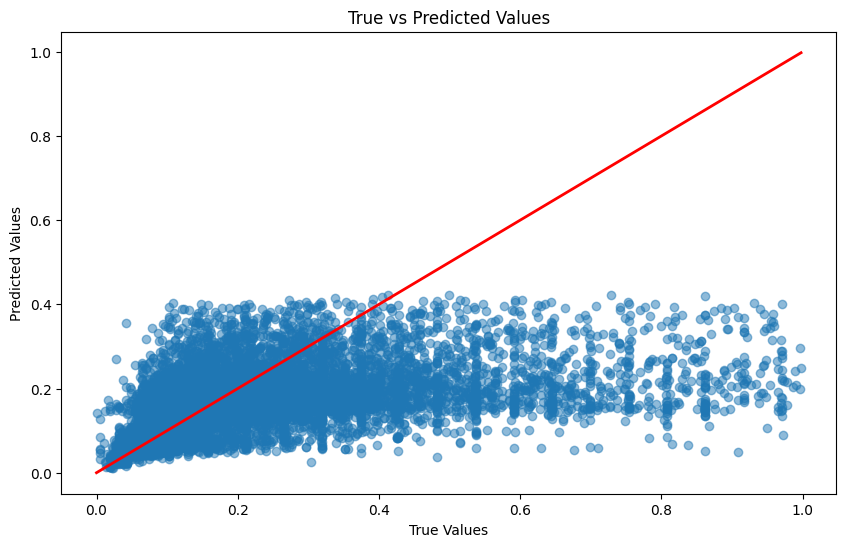

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Line of perfect prediction
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

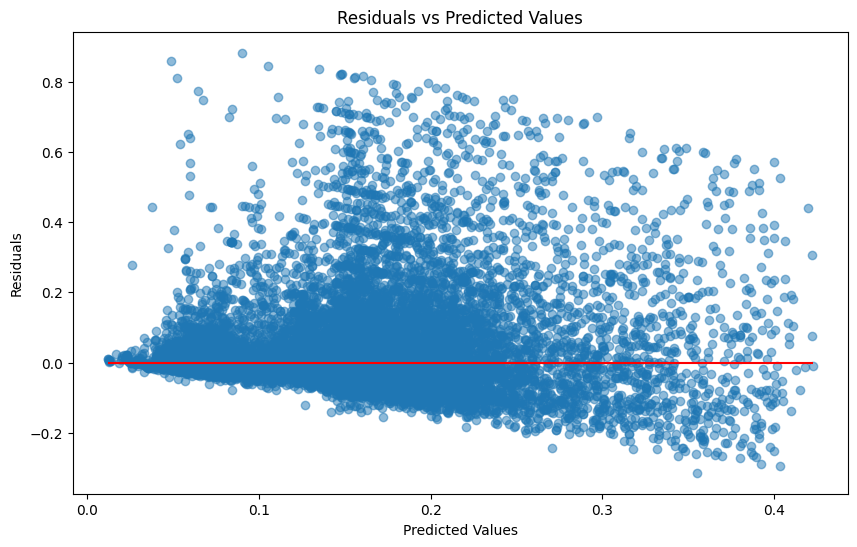

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

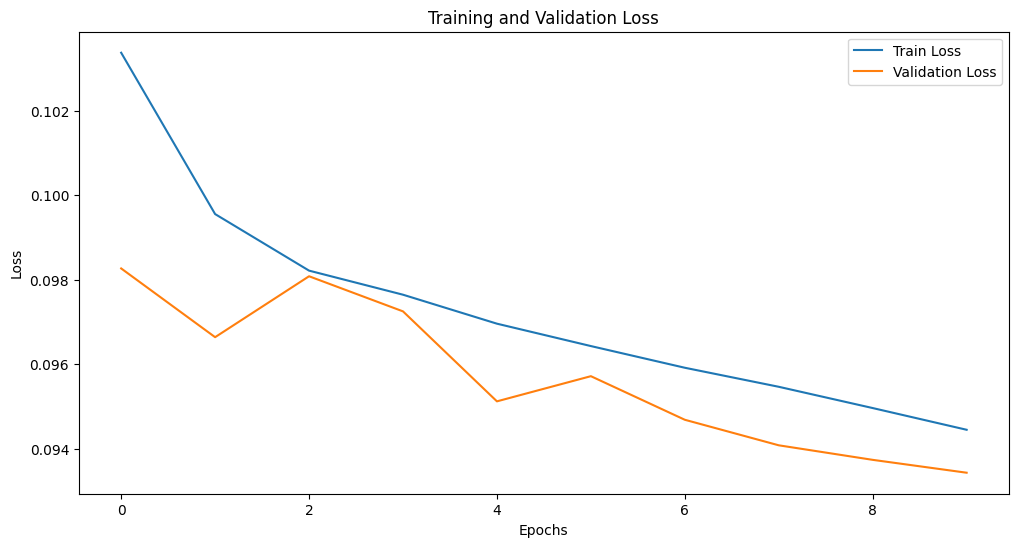

In [ ]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

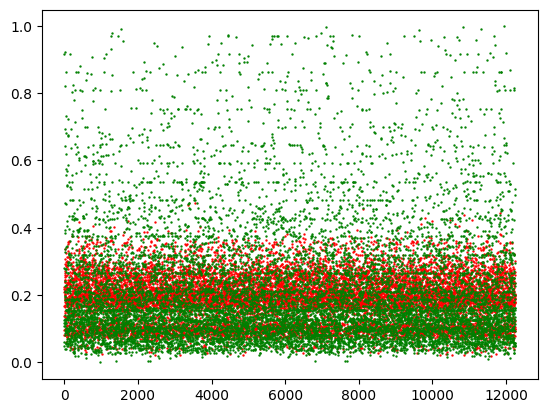

In [34]:
plt.scatter(range(len(X_test)), y_pred, color='red', s=0.5)
plt.scatter(range(len(X_test)),y_test, color='green', s=0.5)
plt.show()

In [36]:
model.save('modelpriceprediction.keras')